In [ ]:
! pip install -U qiskit
! pip install -U pylatexenc
! pip install -U qiskit_algorithms
! pip install -U qiskit_machine_learning

In [21]:
# Import necessary libraries
import numpy as np
np.random.seed(1106)

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from qiskit.primitives import Sampler
from qiskit.circuit.library import PauliFeatureMap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Exercise 1
This notebook will focus on data Quantum Kernel Methods. We will combine them with a classical support vector machine from sklearn

In [22]:
#@title Predefined functions
# Plot the decision boundary
def plot_decision_boundary(X_train, X_test, y_train, y_test, kernel_function, svc):
  feature_1, feature_2 = np.meshgrid(
      np.linspace(X[:, 0].min()-0.5, X[:, 0].max()+0.5, num = 10),
      np.linspace(X[:, 1].min()-0.5, X[:, 1].max()+0.5, num = 10)
  )
  grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
  train_test_similarity_matrix = kernel_function.evaluate(x_vec=grid, y_vec=X_train)
  y_predict = svc.predict(train_test_similarity_matrix)
  y_pred = np.reshape(y_predict, feature_1.shape)
  display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
  display.plot(alpha=0.4)
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', edgecolor='k', cmap='viridis')
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', edgecolor='k', cmap='viridis')
  train_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=10, label='Train')
  test_handle = plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=10, label='Test')
  plt.legend(handles=[train_handle, test_handle], title='Dataset', bbox_to_anchor=(1, 1))
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")
  plt.show()

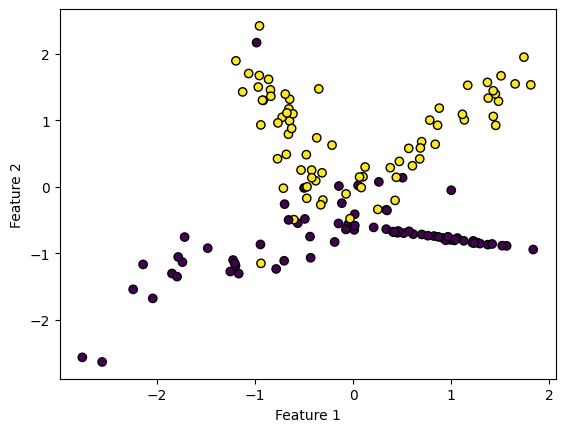

In [23]:
# Same dataset as in the first notebook
X, y = make_classification(n_samples=150, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=1106)
y = np.array([-1 if i == 0 or i == -1 else 1 for i in y]) # the following works better with -1 and 1 as classes instead of 0 and 1
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1106)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

As usual in QML, the first decision has to be the embedding. Here we look at something slightly more advanced than simple roation layer. The PauliFeatureMap with Z, ZZ is the same as the ZZFeatureMap in qiskit, but you can play around with the paulis. The ZZFeatureMap is also known as the IQP embedding.

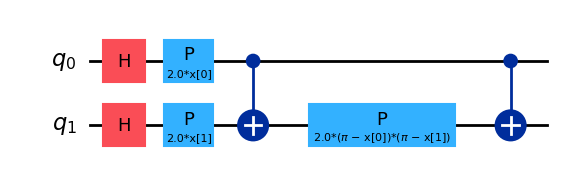

In [24]:
n_qubits = len(X[0])
feature_map = PauliFeatureMap(n_qubits, reps=1, paulis=['Z','ZZ']) #'Y'
feature_map.decompose().draw(output='mpl')

Set up the kernel function

In [25]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel_function = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

Calculate the kernel matrix and the similarity matrix between training and test instances, which we later need to make predictions

In [26]:
kernel_matrix = kernel_function.evaluate(x_vec=X_train)
train_test_similarity_matrix = kernel_function.evaluate(x_vec=X_test, y_vec=X_train)

Have a look at the kernel matrix

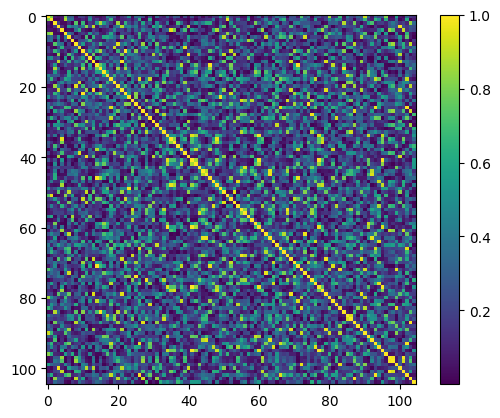

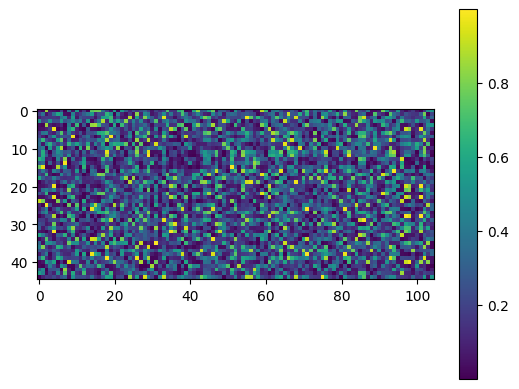

In [27]:
plt.imshow(kernel_matrix)
plt.colorbar()
plt.show()
plt.imshow(train_test_similarity_matrix)
plt.colorbar()
plt.show()

Instantiate the support-vector-classifier and optimize the weigths by fitting

In [28]:
svc = SVC(kernel="precomputed")
svc.fit(kernel_matrix, y_train)

SVC(kernel='precomputed')

In [29]:
# Repeat the above to show the new decision boundaries
y_pred = svc.predict(train_test_similarity_matrix)
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)

The test accuracy of your model is  0.6


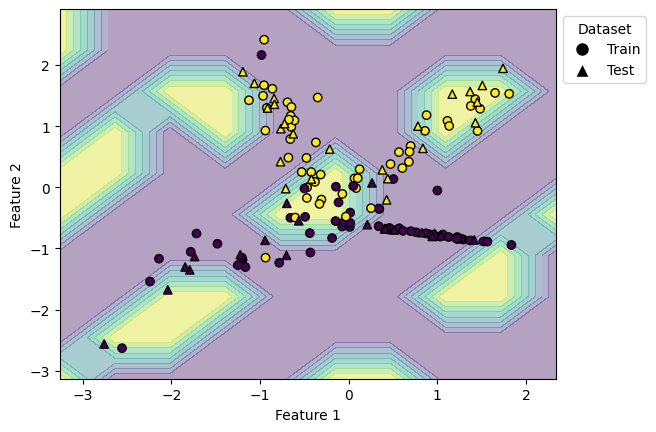

In [30]:
#will run 30s
plot_decision_boundary(X_train, X_test, y_train, y_test, kernel_function, svc)

#Exercise 1
Have a look again at the encoding do you see room for improvement?

In [ ]:
#@title Solution
# The data ranges from -3 to +3 and the rotation angles are 2*x_i. Thus, there is a periodicity. To make the mapping injective, we could scale the data down like dividing through 4.
# To do so simply replace: X = StandardScaler().fit_transform(X)
# With: X = StandardScaler().fit_transform(X)/4
X, y = make_classification(n_samples=150, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=1106)
y = np.array([-1 if i == 0 or i == -1 else 1 for i in y]) # the following works better with -1 and 1 as classes instead of 0 and 1
X = StandardScaler().fit_transform(X)/4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1106)

#as above
kernel_matrix = kernel_function.evaluate(x_vec=X_train)
train_test_similarity_matrix = kernel_function.evaluate(x_vec=X_test, y_vec=X_train)
svc = SVC(kernel="precomputed")
svc.fit(kernel_matrix, y_train)
y_pred = svc.predict(train_test_similarity_matrix)
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)
plot_decision_boundary(X_train, X_test, y_train, y_test, kernel_function, svc)

#Exercise 2
Now the basic pipeline is done, try to add a classical part to the kernel function that acts like $K_{i,j}=exp(-\gamma (1-K_{i,j})^2)$, choose $\gamma=1$ for the beginning, how does the test accuracy change?

In [ ]:
#@title Solution
def add_gaussian(gamma, kernel):
  return np.exp(-gamma*(1-kernel)**2)

gamma = 1
kernel_matrix_gauss = add_gaussian(gamma, kernel_matrix)
train_test_similarity_matrix_gauss = add_gaussian(gamma, train_test_similarity_matrix)

#as above
plt.imshow(kernel_matrix_gauss)
plt.colorbar()
plt.show()
svc = SVC(kernel="precomputed")
svc.fit(kernel_matrix_gauss, y_train)
y_pred = svc.predict(train_test_similarity_matrix_gauss)
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)

#Exercise 3
It looks as if this did not help, try to optimize $\gamma$ using cross validation from the first notebook

In [ ]:
#@title Solution part 1
#Let's further improve the model by finding the optimal k using 5-fold cross validation
gamma_list = np.linspace(0.1,10,100)
cv_scores = []

for gamma in gamma_list:
    kernel_matrix_gauss = add_gaussian(gamma, kernel_matrix)
    scores = cross_val_score(svc, kernel_matrix_gauss, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal k
optimal_gamma = gamma_list[cv_scores.index(max(cv_scores))]
print(f'The optimal gamma is {optimal_gamma}')

# Plot the accuracy for different values of k
plt.figure(figsize=(10, 6))
plt.plot(gamma_list, cv_scores, marker='o')
plt.xlabel(r"$\gamma$")
plt.ylabel("Cross-Validation Accuracy")
plt.show()

In [ ]:
#@title Solution part 2

gamma = 7.1
kernel_matrix_gauss = add_gaussian(gamma, kernel_matrix)
train_test_similarity_matrix_gauss = add_gaussian(gamma, train_test_similarity_matrix)

#as above
plt.imshow(kernel_matrix_gauss)
plt.colorbar()
plt.show()
svc = SVC(kernel="precomputed")
svc.fit(kernel_matrix_gauss, y_train)
y_pred = svc.predict(train_test_similarity_matrix_gauss)
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)